## AVA (AVO) Modelling

Amplitude Variation with Offset is observed on pre-stack seismic gathers  

Amplitudes of the seismic reflections will change with the incidence angle at the  
target horizon.  __Amplitude Variation__ with __Angle (or Offset)__ depends on the
rock properties Vp, Vs and density.  

<img src="nb_images/AVO3.png" width="800" height="700" align="left" />  
<br clear="left"/>   
<br>
<br>  

VSPs offer several advantages over surface seismic in measuring AVA:  
 - VSPs give an __in-situ__ calibration point of the AVA anomalies seen on surface seismic.  
 - Incidence angles can be __measured__ by the downhole 3C geophones.  
 - Seismic waves only travel __one-way__ through the earth with VSP, giving more confidence in the observed  
   amplitudes.

This notebook generates reflection coefficients which vary with angle  
of incidence at the top and base of the middle layer in a 3 layer  
model.


1. Use Zoeppritz equations for exact values for p-waves  

2. Test Shuey's approximations for accuracy

3. Test Ruger's approximation for an anisotropic model

The notebook then generates synthetic traces from the 3 sets or RCs,  
which can then be analyzed:  
- extract the amplitudes from the synthetic traces and analyze  
  AVA
- tuning can be tested by varying the middle layer thickness

** all errors in this code are mine!  



In [1]:
# import the necessary modules
import plot_vsp.avaplots as avaplt
import proc_vsp.avaprocess as avaproc

import proc_vsp.avawavelets as avawav
import plot_vsp.avalogs as avalog
import numpy as np


## 1. Create 3 layer model  

1. Define the physical limits of the model  

2. Define the model properties vp, vs and rho for Zoeppritz and Shuey  

3. Define the model properties epsilon and delta for Ruger's approximation

In [2]:
# 1. model thicknesses can be changed for testing tuning

mod_z=2000 # total thickness of 2 bounding layers
thickness=100 # thickness of middle layer 

In [3]:
# 2.  Enter isotropic model parameters
#     layer one is the top layer, [layer1, layer2, layer3]

vp = [3094.0, 4050.0, 3094.0]  # P-wave velocity (m/s)
vs = [1515.0, 2526.0, 1515.0]  # S-wave velocity (m/s)
rho = [2.4, 2.21, 2.4]  # Density (g/cc)

In [4]:
# 3. Enter anisotropic model parameters
#     layer one is the top layer, [layer1, layer2, layer3]

epsilon = [.1, 0, 0]  # Thomsen's epsilon
delta = [.05, 0, .0]  # Thomsen's delta

### Make a QC model plot

Make sure you understand how the model depths are used.  

Make sure properties are correct.

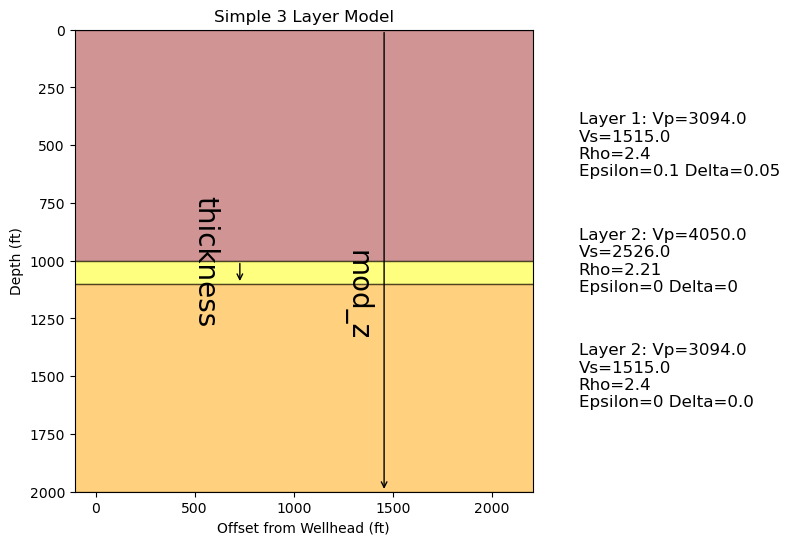

In [5]:
# for this plot, Offset = Depth
mod2d_params={'mod_z':mod_z,
             'thickness':thickness,
             'png':'n'}# save a png image file,'y' or 'n' 

avaplt.model_2d(vp,vs,rho,epsilon,delta,**mod2d_params)


## 2. Create time indexed model logs  

Generate the times to layer boundaries for placing reflection  
coefficients in Two-Way Time (TWT)

In [6]:
# create time indexed logs from the model

modparams={'mod_z':mod_z,        # total thickness of 2 bounding layers
           'thickness' : thickness}         # thickness of middle layer

dt = .001 # time sample rate in seconds, usually between .004 and .00025 seconds
dz = 1 # depth sample rate in meters

tim_logs,tim_samps,tim_layers,dep_logs=avalog.model_logs(vp, vs, rho,epsilon, delta,
                                               dt,dz,**modparams)

### Plot the time and depth models as logs 

Show the depth indexed and time converted model

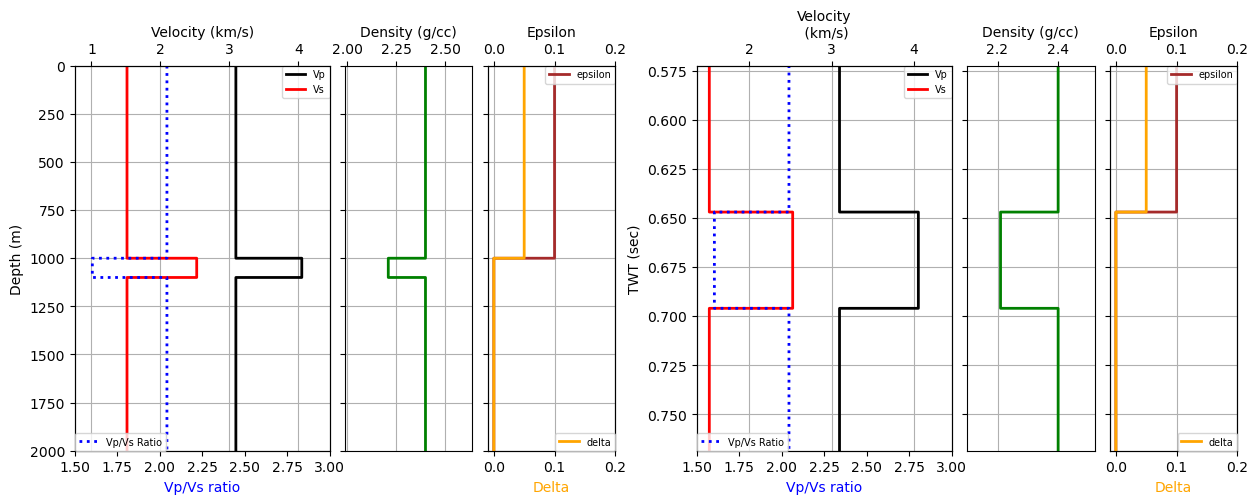

In [7]:
mplotparams={'depth_min':0,
             'depth_max':2000}
avaplt.plot_model(dep_logs,tim_logs,tim_layers,dz,dt,**mplotparams)

## 3. Plan a survey !  

Set up a pseudo-survey to visualize what we are doing. This gives a  
crude idea on the potential angles of incidence given a simple recording geometry.

 - we use straight rays and a 1D model

__Get the critical angle__

It is useful to know the critical angle, to explain odd behaviour of the  
modelled reflection coefficients

In [8]:
# the maximum angle of incidence at both model boundaries
critical_angle_p = np.degrees(np.sin(vp[0]/vp[1]))
critical_angle_s = np.degrees(np.sin(vs[0]/vs[1]))
print(' critical_angle p :',critical_angle_p)
print(' critical_angle s :',critical_angle_s)

 critical_angle p : 39.63605207567892
 critical_angle s : 32.3403973840171


__Plot the survey and angles of incidence__  

The angle of incidence is calculated at one receiver placed on the  
top boundary of the middle layer.  

 - the only thing to change is the maximum source offset

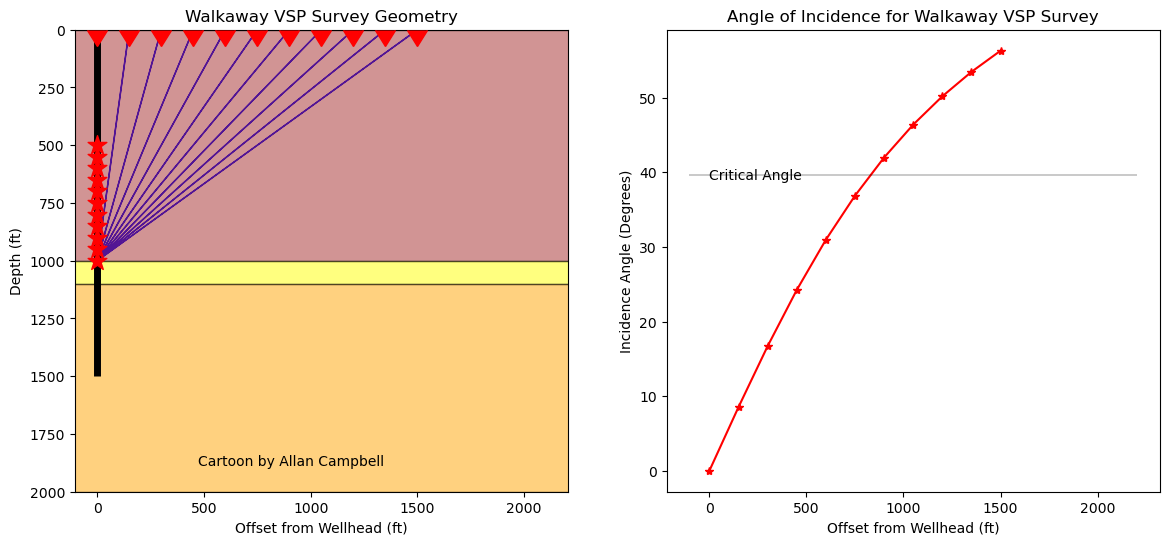

In [9]:

surv_params={'max_offset':1500,
             'mod_z':mod_z,
             'thickness':thickness,
             'critical_angle_p':critical_angle_p,
             'critical_angle_s':critical_angle_s}
avaplt.AVO_offsets( vp,vs,rho,**surv_params)

## 4. Calculate Zoeppritz reflectivities from model parameters  

I will not try to write down the equations in this section, see  
https://wiki.seg.org/wiki/Dictionary:Zoeppritz_equations for details.  

We solve the following equations and extract the value for p down, P up reflectivity:

<img src="nb_images/Zoeppritz1.svg" width="600" height="600" align="left" />  
<br clear="left"/>   
<br>
<br>  

$Z_i = ρ_iVp_i$, $W_i = ρ_iVs_i$, and $Rp$, $Rs$, $Tp$, and $Ts$ are respectively the amplitudes  
of the reflected P- and S-waves and the transmitted P- and S-waves.  

__avaproc.calc_rc__ calculates the reflection coefficients.  
Chose the type of modeling by setting __algo[]__ in the function call line to one of the following  
choices:

__algo[0]__ = Zoeppritz (exact, isotropic)  
__algo[1]__ = 2-term Shuey approximation (isotropic)  
__algo[2]__ = 3-term Shuey (isotropic)  
__algo[3]__ = Ruger (for anisotropic response)

In [10]:
# Select the Zoeppritz element (0) of the algo array for RC generation

max_angle =60 # max angle of incidence (less than critical angle is best)

algo = ['Zoeppritz','2-Term-Shuey','3-Term-Shuey','Ruger']

angles, zp_pp_rc,_ = avaproc.calc_rc(vp, vs, rho,epsilon,delta,algo[0],max_angle )


## 5. Calculate Shuey reflectivities from model parameters  

The 3 term Shuey approximation to the Zoeppritz equations is commonly written as:  

$R(\theta) = R(0) + G*sin(\theta)^2 + F * (tan(\theta)^2 - sin(\theta)^2)$  

where $R(0)$ is the intercept,  

$G*sin(\theta)^2$ is the gradient,  

$F * (tan(\theta)^2 - sin(\theta)^2)$ is curvature (for longer offsets)  

At smaller angles of incidence, 2-term Shuey appriximation can be used: 

$R(\theta) = R(0) + G*sin(\theta)^2$

In [11]:
# Select the Shuey element (1) of the algo array for RC generation
# This returns both 2-term and 3-term Shuey, element (2) is used for 
# captioning only

angles,sh_pp_rc,shuey_attributes = avaproc.calc_rc(vp, vs, rho,epsilon,delta,algo[1],max_angle)
print(' sh_pp_rc.shape :',sh_pp_rc.shape) 


 sh_pp_rc.shape : (61, 4)


## 6. Calculate anisotropic reflectivities  

__Ruger's__ approximation is used to test the difference in reflectivity when one  
or both sides of an interface are anisotropic. See:  

    Rüger, A., 1997, P -wave reflection coefficients for transversely
    isotropic models with vertical and horizontal axis of symmetry:
    Geophysics, v. 62, no. 3, p. 713–722.

In [12]:
# Select the Ruger element (3) of the algo array for RC generation

angles,ruger_pp_rc,_ = avaproc.calc_rc(vp, vs, rho,epsilon,delta,algo[3], max_angle )


## 7. Make plots of reflectivity coefficients  



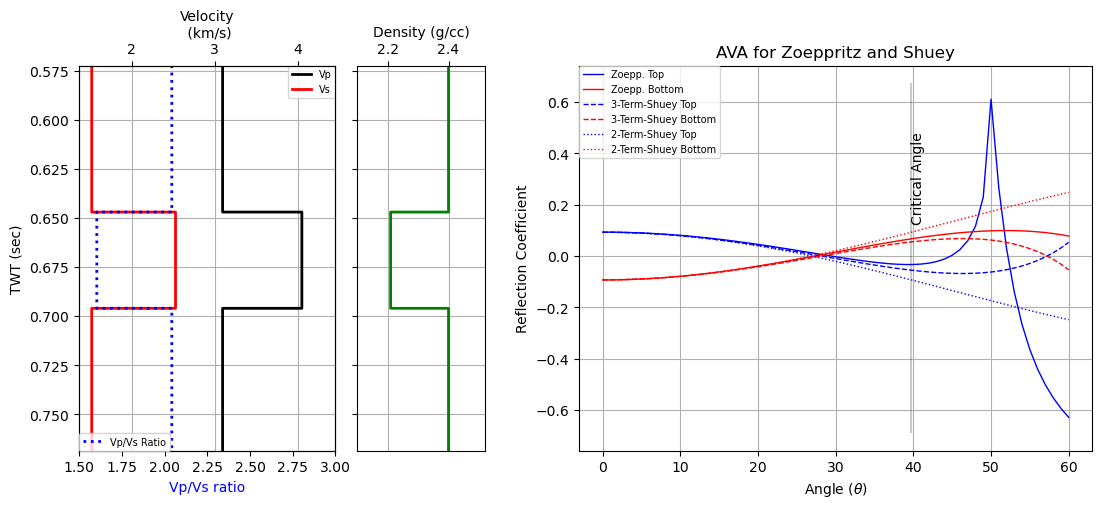

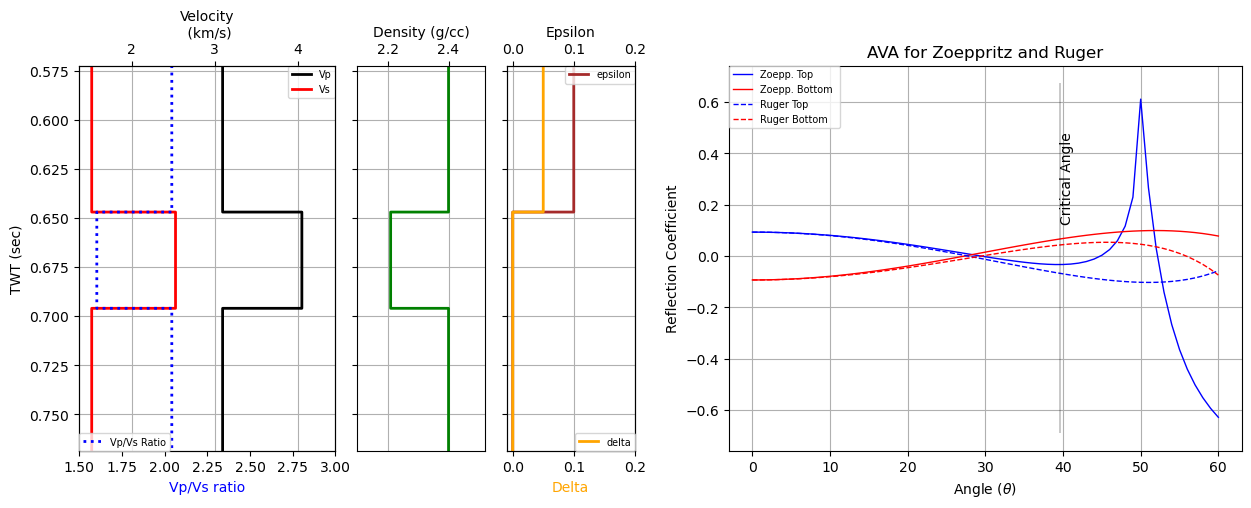

In [13]:

avaplt.plot_rc(zp_pp_rc,sh_pp_rc,angles,tim_logs,tim_layers,dt,algo,critical_angle_p)

avaplt.plot_rc_aniso(zp_pp_rc,ruger_pp_rc,angles,tim_logs,tim_layers,dt,algo,critical_angle_p)


## 6. Plots to Define Gradient and Intercept  

At smaller angles of incidence, 2-term Shuey appriximation can be used: 

$R(\theta) = R(0) + G*sin(\theta)^2$  

If we plot amplitudes against $sin(\theta)^2$ ,  the slope gives us $G$ !

 Top Grad1,Int1  : -0.45382700579830787 0.09260383848345662
 Bottom Grad2,Int2  : 0.45382700579830787 -0.09260383848345662


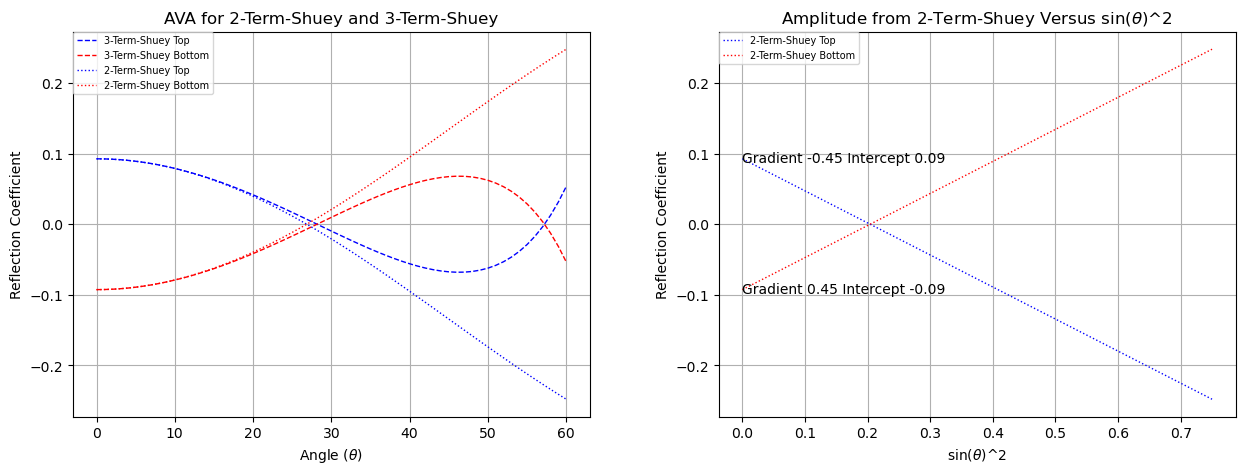

In [14]:
avaplt.plot_grad_int(sh_pp_rc,shuey_attributes,angles,algo)

## 7. Make a synthetic angle gather  

1. Calculate TWT to each layer in model
2. At each angle concatenate the 2 reflectivities at their appropriate times
3. Convolve each trace with a Ricker wavelet


### Traces from Zoeppritz  

The reflection coefficients from step 4 are convolved with a wavelet to  
generate synthetic seismic traces

In [15]:
# Convolve Zoeppritz RCs with a Ricker wavelet
synthparams={'mod_z':mod_z, # do not change here! Total thickness of 2 bounding layers
             'thickness' : thickness,   # do not change here! Thickness of middle layer
             'wave_freq' : 40,         # Central frequency in hertz
             'wave_len' : .128}        # in sec, preferably a power of 2
traces_zoepp = avaproc.model_rc(vp,zp_pp_rc,angles,dt, **synthparams )


### Traces from Shuey  

The reflection coefficients from step 5 are convolved with a wavelet to  
generate seismic traces

In [16]:
# Convolve Shuey 2-term RC with a Ricker wavelet

traces_shuey = avaproc.model_rc(vp,sh_pp_rc,angles,dt, **synthparams )


## 8. Plot the synthetic angle gather

In this example we plot the synthetic seismic traces and then extract AVA attributes from them.  
<br>
The Zoeppritz or the Shuey traces calculated in step 7 can be chosen as input seismic traces.

__Gradient__ and __Intercept__ are estimated from the plotted curves,

The theoretic __Zoeppritz__ curves calculated in step 4 and displayed in step 6 and 5 are  
overlain on the measured curves (labelled seismic on the plot).  

 - since the traces are generated from the model, these curves should overlay exactly  
 if there are no other factors changing the amplitudes
 
 - __tuning__ will change the amplitudes, so try rebuilding the model with a thinner middle layer to  
 see the tuning effect. You will need to re-run the whole notebook

 Top Grad1,Int1  : -0.4317508544686906 0.11613496958115219
 Bottom Grad2,Int2  : 0.2810931383985067 -0.0729671982338879


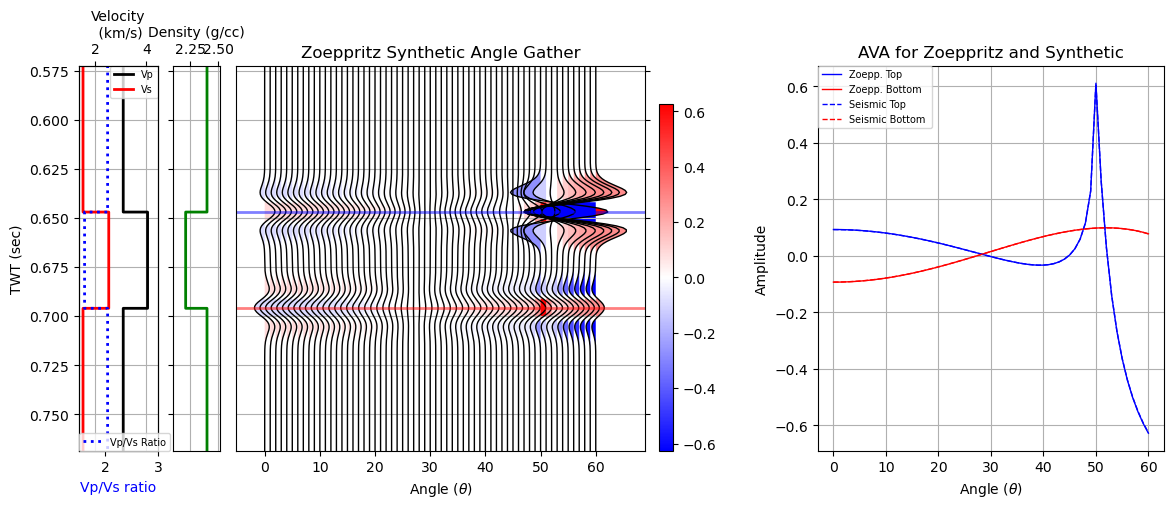

In [17]:
plotparams={
          'ang_min':0,
          'scaler':20,
          'time_lines':'y'} # draw time lines for boundaries on wiggles 'y' or 'n'
avaplt.plot_gath_rc(zp_pp_rc,traces_zoepp,angles,tim_logs,tim_layers,dt,algo[0],**plotparams)


## References  

The functions I use (and adapt) are from these sources:

Alessandro Amato del Monte's __AVO Explorer__  
https://github.com/aadm    

Some functions from Agile Scientific's __Bruges__ collections are incorporated:  
https://github.com/agilescientific/bruges/blob/main/bruges/reflection/reflection.py,  
https://github.com/agilescientific/bruges/blob/main/bruges/rockphysics/anisotropy.py  

I make use of Felipe Melo's __avo__ github repo  
https://github.com/ffigura/avo  

Some functions from Tola Abiodun's __pyavo__ are used.  
https://github.com/TolaAbiodun/pyavo/blob/master/pyavo/seismodel/tuning_prestack.py